# GAN: Generate synthetic time-series data

Without any _Seq2Seq RNN_ architecture/concept.

In [ ]:
# Specify GPU to be used-
%env CUDA_DEVICE_ORDER = PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES = 0

In [1]:
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm
from tqdm import trange
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pickle

C:\Users\Arjun\anaconda3\envs\pytorch-cpu\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print(f"torch version: {torch.__version__}")

torch version: 1.11.0


In [3]:
# Check if there are multiple devices (i.e., GPU cards)-
print(f"Number of GPU(s) available = {torch.cuda.device_count()}")

# Which GPU Is The Current GPU?
# print(f"current GPU: {torch.cuda.current_device()}")

# Get the name of the current GPU-
# print(f"Current GPU name: {torch.cuda.get_device_name(torch.cuda.current_device())}")

# Is PyTorch using a GPU?
# print(f"Is PyTorch using a GPU? {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"Current GPU: {torch.cuda.current_device()}")
    print(f"Current GPU name: {torch.cuda.get_device_name(torch.cuda.current_device())}")
else:
    print("PyTorch does not have access to GPU")

Number of GPU(s) available = 0
PyTorch does not have access to GPU


In [4]:
# Device configuration-
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Available device is {device}')

Available device is cpu


In [5]:
# Hyper-parameters-
num_epochs = 50
batch_size = 256

In [6]:
# We have two learning rates:

# Generator LR-
generator_learning_rate = 0.0012

# Discriminator LR-
discriminator_learning_rate = 0.0012

### Data pre-processing

In [7]:
class TimeSeriesDataset(Dataset):
    def __init__(self, filename):
        data = pd.read_csv(filename)
        
        # Convert 'Dae' column to datetime-
        data['Date'] = pd.to_datetime(data['Date'])
        
        # Sort in increasing order for 'Date' column-
        data.sort_values(by = 'Date', ascending = True, inplace = True)
        
        # Reset indices-
        data.reset_index(drop = True, inplace = True)
        
        # Write any data pre-processing steps here.

        # Initialize a MinMax scaler-
        mm_scaler = MinMaxScaler(feature_range = (0, 1))
        data_scaled = mm_scaler.fit_transform(data.iloc[:, 1:].to_numpy())
        
        # Convert from np array to pd.DataFrame-
        # data_scaled = pd.DataFrame(data_scaled, columns = cols)
        
        # Convert to torch tensors-
        self.data_scaled = torch.tensor(data_scaled, dtype = torch.float32)
        
        # Save MinMaxScaler for later use/inverse scaling-
        with open("Trained_MinMaxScaler.pickle", "wb") as file:
            pickle.dump(mm_scaler, file)
    
    
    def __len__(self):
        return len(self.data_scaled)
    
    
    def __getitem__(self, idx):
        return self.data_scaled[idx]


In [8]:
# Initialize time-series dataset-
data_torch = TimeSeriesDataset(filename = "C:/Users/Arjun/Downloads/yahoo_stock.csv")

In [9]:
# Sanity checks-
len(data_torch)

1825

In [10]:
# Create data loader
data_loader = DataLoader(dataset = data_torch, batch_size = 256, shuffle = False)
# shuffle = False due to time-series data!

In [11]:
print(f"len(data_loader) = {len(data_loader)}")

len(data_loader) = 8


In [12]:
len(data_torch) / 256

7.12890625

In [13]:
# Sanity check: Get a batch of data-
x = next(iter(data_loader))

In [14]:
print(f"batch-size shape: {x.shape}")

batch-size shape: torch.Size([256, 6])


In [15]:
del x

### Design GAN architecture

- Since the input data has been normalized to be in the range: [-1, 1], tanh activation function is used in the generator and discriminator.

- Fully-connected GAN architecture is being implemented.

- The discriminator is just a binary classifier.

In [16]:
class GAN_Discriminator(nn.Module):
    def __init__(self):
        super(GAN_Discriminator, self).__init__()
        
        self.layer = nn.Linear(in_features = 6, out_features = 128)
        self.dropout = nn.Dropout(p = 0.5)
        self.output = nn.Linear(in_features = 128, out_features = 1)
    
    
    def forward(self, x):
        x = F.leaky_relu(self.dropout(self.layer(x)))
        x = torch.tanh(self.output(x))
        return x
    
    
    def shape_computation(self, x):
        print(f"Input shape to Discriminator: {x.shape}")
        x = F.leaky_relu(self.dropout(self.layer(x)))
        print(f"First dense layer output shape: {x.shape}")
        x = torch.tanh(self.output(x))
        print(f"Discriminator output shape: {x.shape}")
        return None
    

In [17]:
class GAN_Generator(nn.Module):
    '''
    Generator receives its input from noise. The noise has the dimension: NCHW.
    The noise vector is sampled from a normal distribution.
    '''
    def __init__(self, latent_dim = 100):
        super(GAN_Generator, self).__init__()
        self.latent_dim = latent_dim
        
        self.layer = nn.Linear(in_features = self.latent_dim, out_features = 128)
        self.dropout = nn.Dropout(p = 0.5)
        self.layer2 = nn.Linear(in_features = 128, out_features = 300) 
        self.generator_output = nn.Linear(in_features = 300, out_features = 6)
        
        self.weights_initialization()
    
    
    def weights_initialization(self):
        '''
        When we define all the modules such as the layers in '__init__()'
        method above, these are all stored in 'self.modules()'.
        We go through each module one by one. This is the entire network,
        basically.
        '''
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                # nn.init.xavier_normal_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    
    def forward(self, x):
        '''
        The noise vector 'x' has the shape: NCHW. Or,
        batch-size, number of channels, height, width.
        '''
        x = torch.flatten(x, start_dim = 1)
        x = F.leaky_relu(self.dropout(self.layer(x)))
        # x = self.dropout(nn.LeakyReLU(self.layer(x)))
        x = F.leaky_relu(self.dropout(self.layer2(x)))
        x = torch.tanh(self.generator_output(x))
        # x = x.view(x.size(0), self.color_channels, self.image_height, self.image_width)
        return x
    
    
    def shape_computation(self, x):
        print(f"Input shape to Generator: {x.shape}")
        x = torch.flatten(x, start_dim = 1)
        print(f"Reshaped shape: {x.shape}")
        x = F.leaky_relu(self.dropout(self.layer(x)))
        print(f"First dense layer output shape: {x.shape}")
        x = F.leaky_relu(self.dropout(self.layer2(x)))
        print(f"Second dense layer output shape: {x.shape}")
        x = torch.tanh(self.generator_output(x))
        print(f"Generator output shape: {x.shape}")
        # x = x.view(x.size(0), self.color_channels, self.image_height, self.image_width)
        # print(f"Generator reshaped output shape: {x.shape}")
        return None
    

In [18]:
class GAN(nn.Module):
    def __init__(self, latent_dim = 100,):
        super(GAN, self).__init__()
        self.latent_dim = latent_dim
        
        self.generator = GAN_Generator(latent_dim = self.latent_dim)
        
        self.discriminator = GAN_Discriminator()
    
    """
    def forward(self, x, z):
        img = self.generator(z)
        logits = self.discriminator(img)
    """
    
    def generator_forward(self, z):
        data_gen = self.generator(z)
        return data_gen
    
    
    def discriminator_forward(self, x):
        logits = self.discriminator(x)
        return logits
    

In [19]:
# Specify latent space dimensionality-
latent_dimensionality = 100

In [20]:
# Initialize GAN model and push to 'device'-
model = GAN(latent_dim = latent_dimensionality).to(device)

In [21]:
# Count number of layer-wise parameters and total parameters-
tot_params = 0
for param in model.parameters():
    print(f"layer.shape = {param.shape} has {param.nelement()} parameters")
    tot_params += param.nelement()

print(f"\nFully-connected GAN has {tot_params} parameters\n")

layer.shape = torch.Size([128, 100]) has 12800 parameters
layer.shape = torch.Size([128]) has 128 parameters
layer.shape = torch.Size([300, 128]) has 38400 parameters
layer.shape = torch.Size([300]) has 300 parameters
layer.shape = torch.Size([6, 300]) has 1800 parameters
layer.shape = torch.Size([6]) has 6 parameters
layer.shape = torch.Size([128, 6]) has 768 parameters
layer.shape = torch.Size([128]) has 128 parameters
layer.shape = torch.Size([1, 128]) has 128 parameters
layer.shape = torch.Size([1]) has 1 parameters

Fully-connected GAN has 54459 parameters



In [22]:
print(f"\nFully-connected GAN model's layer names are:")
for layer in model.state_dict().keys():
    print(f"{layer} has dimension = {model.state_dict()[layer].shape}")


Fully-connected GAN model's layer names are:
generator.layer.weight has dimension = torch.Size([128, 100])
generator.layer.bias has dimension = torch.Size([128])
generator.layer2.weight has dimension = torch.Size([300, 128])
generator.layer2.bias has dimension = torch.Size([300])
generator.generator_output.weight has dimension = torch.Size([6, 300])
generator.generator_output.bias has dimension = torch.Size([6])
discriminator.layer.weight has dimension = torch.Size([128, 6])
discriminator.layer.bias has dimension = torch.Size([128])
discriminator.output.weight has dimension = torch.Size([1, 128])
discriminator.output.bias has dimension = torch.Size([1])


In [23]:
# Initialize gradient descent optimizers-
'''
The optimizer should only update the parameters for their respective
models. Using 'model.parameters' will update both the discriminator
and the generator.
'''

# You might try with SGD for the generator.
optimizer_generator = torch.optim.Adam(
    model.generator.parameters(), betas = (0.5, 0.999),
    lr = generator_learning_rate
)

optimizer_discriminator = torch.optim.Adam(
    model.discriminator.parameters(), betas = (0.5, 0.999),
    lr = discriminator_learning_rate
)

In [24]:
# Define loss objective-
loss_fn = F.binary_cross_entropy_with_logits

In [25]:
def train_one_epoch(model, train_dataset, dataloader, loss_fn, latent_dim = 100):
    '''
    Train GAN model for one epoch using supplied parameters/objects.
    '''
    
    # Place model to device-
    model.to(device)
    
    # Enable training mode-
    model.train()

    for batch_idx, features in tqdm(
    # for batch_idx, (features, _) in tqdm(
        enumerate(dataloader), total = int(len(train_dataset) / dataloader.batch_size)
    ):
        local_batch_size = features.size(0)
        
        # Real/actual images-
        real_images = features.to(device)
        
        # Create real labels (all ones)-
        real_labels = torch.ones(local_batch_size, device = device)
        
        # Generated/fake images-
        noise = torch.randn(local_batch_size, latent_dim, 1, 1, device = device)
        # Sampled from a normal distribution. Works better as compared to a
        # uniform distribution.
        
        # Create fake images using GAN's generator from noise-
        fake_images = model.generator_forward(noise)
        
        # Create fake labels (all zeroes)-
        fake_labels = torch.zeros(local_batch_size, device = device)
        
        # Create flipped fake labels. Our trick of fooling the discriminator when
        # training the generator-
        flipped_fake_labels = real_labels
        
        
        # Train Discriminator:
        
        # Empty accumulated gradients-
        optimizer_discriminator.zero_grad()
        
        # Compute discriminator loss on real images-
        discriminator_pred_real = model.discriminator_forward(real_images).view(-1)
        # Convert from (N, 1) -> N; just removing the last dimension. Can also use torch.squeeze().
        
        real_loss = loss_fn(discriminator_pred_real, real_labels)
        # real_loss.backward()
        
        # Compute discriminator loss on fake images-
        discriminator_pred_fake = model.discriminator_forward(fake_images.detach()).view(-1)
        # We are not optimizing the generator here. The generator is frozen. Using detach to
        # remove it from the generator graph.
        
        fake_loss = loss_fn(discriminator_pred_fake, fake_labels)
        # fake_loss.backward()
        
        # Total combined loss-
        discriminator_loss = 0.5 * (real_loss + fake_loss)
        
        # Perform backward propagation-
        discriminator_loss.backward()
        
        # Update parameters for discriminator-
        optimizer_discriminator.step()
        
        
        # Train Generator:
        
        # Empty accumulated gradients-
        optimizer_generator.zero_grad()
        
        # Compute discriminator loss on fake images using flipped labels-
        discriminator_pred_fake = model.discriminator_forward(fake_images).view(-1)
        gener_loss = loss_fn(discriminator_pred_fake, flipped_fake_labels)
        
        # Perform backward propagation-
        gener_loss.backward()
        
        # Update parameters for discriminator-
        optimizer_generator.step()
        
        # We are only updating the generator here. The parameters for the discriminator remain
        # frozen. The generator is updated such that in the next iteration, it is better at
        # fooling the discriminator by getting the outputs as 1s for 'discriminator_pred_fake'
        # above which are similar to 'fake_labels' by making them similar.
    
    
    return gener_loss.item(), discriminator_loss.item()


In [26]:
def test_one_epoch(model, test_dataset, dataloader, loss_fn, latent_dim = 100):
    '''
    Validate GAN model on validation/test dataset using supplied parameters/objects.
    '''
    
    # Place model to device-
    model.to(device)
    
    # Enable evaluation mode-
    model.eval()
    
    with torch.no_grad():
        for batch_idx, features in tqdm(
        # for batch_idx, (features, _) in tqdm(
            enumerate(dataloader), total = int(len(test_dataset) / dataloader.batch_size)
        ):
            local_batch_size = features.size(0)
        
            # Real/actual images-
            real_images = features.to(device)
        
            # Create real labels (all ones)-
            real_labels = torch.ones(local_batch_size, device = device)
        
            # Generated/fake images-
            noise = torch.randn(local_batch_size, latent_dim, 1, 1, device = device)
            # Sampled from a normal distribution. Works better as compared to a
            # uniform distribution.
        
            # Create fake images using GAN's generator from noise-
            fake_images = model.generator_forward(noise)
        
            # Create fake labels (all zeroes)-
            fake_labels = torch.zeros(local_batch_size, device = device)
        
            # Create flipped fake labels. Our trick of fooling the discriminator when
            # training the generator-
            flipped_fake_labels = real_labels
        
            # Compute discriminator loss on real images-
            discriminator_pred_real = model.discriminator_forward(real_images).view(-1)
            # Convert from (N, 1) -> N; just removing the last dimension. Can also use torch.squeeze().
        
            real_loss = loss_fn(discriminator_pred_real, real_labels)
            
        
            # Compute discriminator loss on fake images-
            discriminator_pred_fake = model.discriminator_forward(fake_images.detach()).view(-1)
            # We are not optimizing the generator here. The generator is frozen. Using detach to
            # remove it from the generator graph.
        
            fake_loss = loss_fn(discriminator_pred_fake, fake_labels)
        
        
            # Total combined loss-
            discriminator_loss = 0.5 * (real_loss + fake_loss)
        
            # Compute discriminator loss on fake images using flipped labels-
            discriminator_pred_fake = model.discriminator_forward(fake_images).view(-1)
            gener_loss = loss_fn(discriminator_pred_fake, flipped_fake_labels)
    
    
    return gener_loss.item(), discriminator_loss.item()


In [27]:
# Python3 dict to contain training metrics-
training_metrics = {}

In [28]:
# Losses for saving 'best' individual generator and
# discriminator models-
best_generator_loss = 10000
best_discriminator_loss = 10000

In [29]:
print(f"Train GAN model for {num_epochs} epochs")

Train GAN model for 50 epochs


In [30]:
for epoch in range(num_epochs):
    
    # Train GAN for one epoch on training data-
    train_generator_epoch_loss, train_discriminator_epoch_loss = train_one_epoch(
        model = model, train_dataset = data_torch,
        dataloader = data_loader, loss_fn = loss_fn,
        latent_dim = latent_dimensionality
    )
    '''
    # Validate trained GAN for one epoch on validation dataset-
    test_generator_epoch_loss, test_discriminator_epoch_loss = test_one_epoch(
        model = model, test_dataset = test_dataset,
        dataloader = test_loader, loss_fn = loss_fn,
        latent_dim = latent_dim
    )
    '''
    
    print(f"Epoch = {epoch + 1}; training generator loss = {train_generator_epoch_loss:.5f}"
          f", train discriminator loss per batch =  {train_discriminator_epoch_loss:.5f}; "
          # f" validation generator loss = {test_generator_epoch_loss:.5f} & validation generator"
          # f" loss = {test_discriminator_epoch_loss:.5f}"
         )
    
    # You can also save the 'best' validation losses for generator & discriminator, instead-
    if train_generator_epoch_loss < best_generator_loss:
        # Update 'best' generator loss-
        best_generator_loss = train_generator_epoch_loss
        
        # Save 'best' parameters for generator-
        torch.save(model.generator.state_dict(), 'GAN_FC_yahoo_stocks_best_generator_parameters.pth')
    
    if train_discriminator_epoch_loss < best_discriminator_loss:
        # Update 'best' discriminator loss-
        best_discriminator_loss = train_discriminator_epoch_loss
        
        # Save 'best' parameters for generator-
        torch.save(model.discriminator.state_dict(), 'GAN_FC_yahoo_stocks_best_discriminator_parameters.pth')
        
    # Save training metrics-
    training_metrics[epoch] = {
        'train_generator_loss': train_generator_epoch_loss,
        'train_discriminator_loss': train_discriminator_epoch_loss,
        # 'validation_generator_loss': test_generator_epoch_loss,
        # 'validation_discriminator_loss': test_discriminator_epoch_loss
    }
    
    

8it [00:00, 151.82it/s]                                                                                                


Epoch = 1; training generator loss = 0.77851, train discriminator loss per batch =  0.66124; 


8it [00:00, 170.50it/s]                                                                                                


Epoch = 2; training generator loss = 0.76921, train discriminator loss per batch =  0.66147; 


8it [00:00, 168.44it/s]                                                                                                


Epoch = 3; training generator loss = 0.84199, train discriminator loss per batch =  0.69013; 


8it [00:00, 120.00it/s]                                                                                                


Epoch = 4; training generator loss = 0.88422, train discriminator loss per batch =  0.70231; 


8it [00:00, 175.06it/s]                                                                                                


Epoch = 5; training generator loss = 0.91693, train discriminator loss per batch =  0.66603; 


8it [00:00, 120.68it/s]                                                                                                


Epoch = 6; training generator loss = 0.89678, train discriminator loss per batch =  0.66953; 


8it [00:00, 122.31it/s]                                                                                                


Epoch = 7; training generator loss = 0.88644, train discriminator loss per batch =  0.67718; 


8it [00:00, 117.35it/s]                                                                                                


Epoch = 8; training generator loss = 0.88973, train discriminator loss per batch =  0.66228; 


8it [00:00, 118.84it/s]                                                                                                


Epoch = 9; training generator loss = 0.84421, train discriminator loss per batch =  0.69416; 


8it [00:00, 165.39it/s]                                                                                                


Epoch = 10; training generator loss = 0.89117, train discriminator loss per batch =  0.65499; 


8it [00:00, 115.88it/s]                                                                                                


Epoch = 11; training generator loss = 0.94387, train discriminator loss per batch =  0.53858; 


8it [00:00, 124.96it/s]                                                                                                


Epoch = 12; training generator loss = 0.65941, train discriminator loss per batch =  0.65103; 


8it [00:00, 157.31it/s]                                                                                                


Epoch = 13; training generator loss = 0.87598, train discriminator loss per batch =  0.64371; 


8it [00:00, 120.27it/s]                                                                                                


Epoch = 14; training generator loss = 0.88223, train discriminator loss per batch =  0.67020; 


8it [00:00, 132.38it/s]                                                                                                


Epoch = 15; training generator loss = 0.89732, train discriminator loss per batch =  0.65376; 


8it [00:00, 127.74it/s]                                                                                                


Epoch = 16; training generator loss = 0.95760, train discriminator loss per batch =  0.63057; 


8it [00:00, 95.28it/s]                                                                                                 


Epoch = 17; training generator loss = 0.94424, train discriminator loss per batch =  0.66770; 


8it [00:00, 118.16it/s]                                                                                                


Epoch = 18; training generator loss = 0.94766, train discriminator loss per batch =  0.66776; 


8it [00:00, 132.84it/s]                                                                                                


Epoch = 19; training generator loss = 0.86504, train discriminator loss per batch =  0.67930; 


8it [00:00, 150.58it/s]                                                                                                


Epoch = 20; training generator loss = 0.90577, train discriminator loss per batch =  0.69343; 


8it [00:00, 120.00it/s]                                                                                                


Epoch = 21; training generator loss = 0.87079, train discriminator loss per batch =  0.66054; 


8it [00:00, 122.21it/s]                                                                                                


Epoch = 22; training generator loss = 0.78529, train discriminator loss per batch =  0.68075; 


8it [00:00, 121.84it/s]                                                                                                


Epoch = 23; training generator loss = 0.77459, train discriminator loss per batch =  0.71465; 


8it [00:00, 158.96it/s]                                                                                                


Epoch = 24; training generator loss = 0.73324, train discriminator loss per batch =  0.72338; 


8it [00:00, 159.82it/s]                                                                                                


Epoch = 25; training generator loss = 0.72021, train discriminator loss per batch =  0.75694; 


8it [00:00, 151.63it/s]                                                                                                


Epoch = 26; training generator loss = 0.69035, train discriminator loss per batch =  0.73677; 


8it [00:00, 166.15it/s]                                                                                                


Epoch = 27; training generator loss = 0.63118, train discriminator loss per batch =  0.75406; 


8it [00:00, 159.85it/s]                                                                                                


Epoch = 28; training generator loss = 0.63793, train discriminator loss per batch =  0.74408; 


8it [00:00, 161.66it/s]                                                                                                


Epoch = 29; training generator loss = 0.63828, train discriminator loss per batch =  0.75164; 


8it [00:00, 160.32it/s]                                                                                                


Epoch = 30; training generator loss = 0.63842, train discriminator loss per batch =  0.75261; 


8it [00:00, 147.77it/s]                                                                                                


Epoch = 31; training generator loss = 0.63170, train discriminator loss per batch =  0.73797; 


8it [00:00, 176.40it/s]                                                                                                


Epoch = 32; training generator loss = 0.66159, train discriminator loss per batch =  0.72752; 


8it [00:00, 158.12it/s]                                                                                                


Epoch = 33; training generator loss = 0.65933, train discriminator loss per batch =  0.72938; 


8it [00:00, 249.13it/s]                                                                                                


Epoch = 34; training generator loss = 0.65279, train discriminator loss per batch =  0.72430; 


8it [00:00, 159.38it/s]                                                                                                


Epoch = 35; training generator loss = 0.65700, train discriminator loss per batch =  0.70445; 


8it [00:00, 149.85it/s]                                                                                                


Epoch = 36; training generator loss = 0.66959, train discriminator loss per batch =  0.72104; 


8it [00:00, 126.84it/s]                                                                                                


Epoch = 37; training generator loss = 0.66763, train discriminator loss per batch =  0.71526; 


8it [00:00, 116.85it/s]                                                                                                


Epoch = 38; training generator loss = 0.68655, train discriminator loss per batch =  0.70497; 


8it [00:00, 96.49it/s]                                                                                                 


Epoch = 39; training generator loss = 0.68604, train discriminator loss per batch =  0.70912; 


8it [00:00, 119.64it/s]                                                                                                


Epoch = 40; training generator loss = 0.68794, train discriminator loss per batch =  0.70227; 


8it [00:00, 168.53it/s]                                                                                                


Epoch = 41; training generator loss = 0.68084, train discriminator loss per batch =  0.70249; 


8it [00:00, 160.12it/s]                                                                                                


Epoch = 42; training generator loss = 0.67065, train discriminator loss per batch =  0.71495; 


8it [00:00, 150.44it/s]                                                                                                


Epoch = 43; training generator loss = 0.67335, train discriminator loss per batch =  0.69433; 


8it [00:00, 161.99it/s]                                                                                                


Epoch = 44; training generator loss = 0.69843, train discriminator loss per batch =  0.68164; 


8it [00:00, 159.20it/s]                                                                                                


Epoch = 45; training generator loss = 0.68301, train discriminator loss per batch =  0.70479; 


8it [00:00, 155.41it/s]                                                                                                


Epoch = 46; training generator loss = 0.68212, train discriminator loss per batch =  0.69855; 


8it [00:00, 168.61it/s]                                                                                                


Epoch = 47; training generator loss = 0.69746, train discriminator loss per batch =  0.69645; 


8it [00:00, 166.60it/s]                                                                                                


Epoch = 48; training generator loss = 0.67573, train discriminator loss per batch =  0.69793; 


8it [00:00, 159.82it/s]                                                                                                


Epoch = 49; training generator loss = 0.68360, train discriminator loss per batch =  0.69184; 


8it [00:00, 170.52it/s]                                                                                                

Epoch = 50; training generator loss = 0.68616, train discriminator loss per batch =  0.69786; 


In [31]:
# Save trained GAN parameters-
torch.save(model.state_dict(), 'GAN_FC_yahoo_stock-Trained_Parameters.pth')

In [32]:
# Save training metrics as pickled object-
with open("GAN_FC_yahoo_stock-training_metrics.pkl", "wb") as file:
    pickle.dump(training_metrics, file)

In [ ]:
'''
# Sanity check: Inidiatlize a new GAN model and push to device-
trained_model = GAN(latent_dim = 100).to(device)
'''

# trained_model.load_state_dict(torch.load('GAN_FC_yahoo_stock-Trained_Parameters.pth'))

# del trained_model

In [46]:
# Load 'best' trained GAN parameters-
model.generator.load_state_dict(torch.load("GAN_FC_yahoo_stocks_best_generator_parameters.pth"))

<All keys matched successfully>

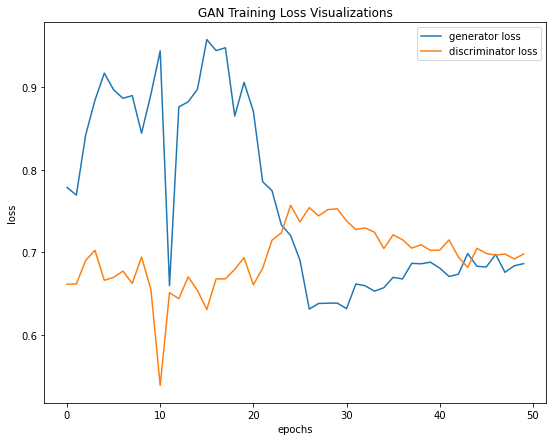

In [33]:
# Visualize training losses
plt.figure(figsize = (9, 7))
plt.plot([training_metrics[e]['train_generator_loss'] for e in training_metrics.keys()], label = 'generator loss')
plt.plot([training_metrics[e]['train_discriminator_loss'] for e in training_metrics.keys()], label = 'discriminator loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("GAN Training Loss Visualizations")
plt.legend(loc = 'best')
plt.show()

In [34]:
# Generate batch of latent noise vector for evaluating/visualizing
# the training progress of generator.
# Sample from a standard Gaussian distribution-
fixed_noise = torch.randn(batch_size, latent_dimensionality, 1, 1, device = device)

In [35]:
fixed_noise.shape

torch.Size([256, 100, 1, 1])

### Use trained generator to generate synthetic data from randomly sampled noise vector

In [47]:
# Get trained generator output using 'fixed_noise' from above-
generator_output = model.generator_forward(fixed_noise).cpu().detach().numpy()

In [48]:
# Sanity check-
generator_output.shape

(256, 6)

In [49]:
# Get a batch of real data-
x = next(iter(data_loader))

#### Visualize comparisons betweeen real vs. generated data ∀ features

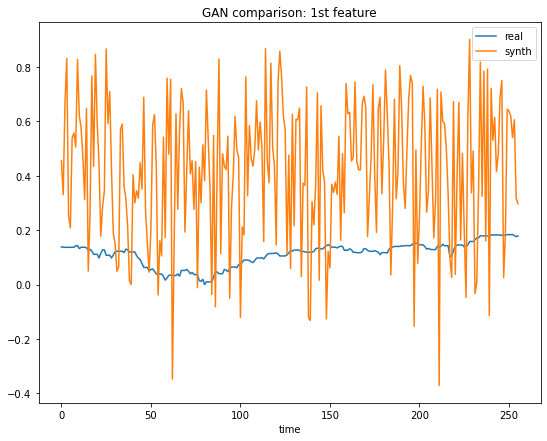

In [50]:
plt.figure(figsize = (9, 7))
plt.plot(x[:, 0], label = 'real')
plt.plot(generator_output[:, 0], label = 'synth')
plt.xlabel("time")
plt.title("GAN comparison: 1st feature")
plt.legend(loc = 'best')
plt.show()

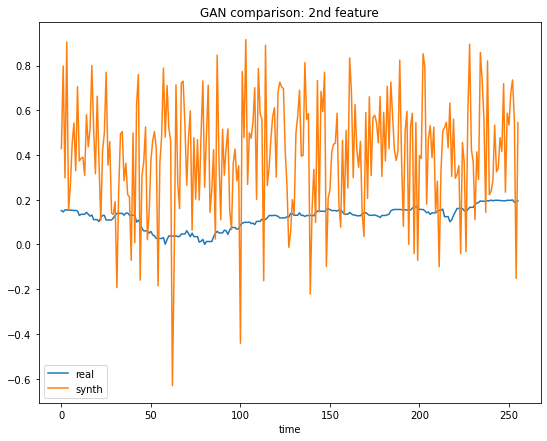

In [51]:
plt.figure(figsize = (9, 7))
plt.plot(x[:, 1], label = 'real')
plt.plot(generator_output[:, 1], label = 'synth')
plt.xlabel("time")
plt.title("GAN comparison: 2nd feature")
plt.legend(loc = 'best')
plt.show()

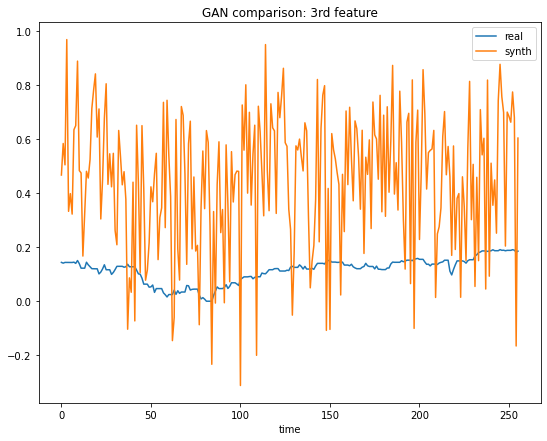

In [52]:
plt.figure(figsize = (9, 7))
plt.plot(x[:, 2], label = 'real')
plt.plot(generator_output[:, 2], label = 'synth')
plt.xlabel("time")
plt.title("GAN comparison: 3rd feature")
plt.legend(loc = 'best')
plt.show()

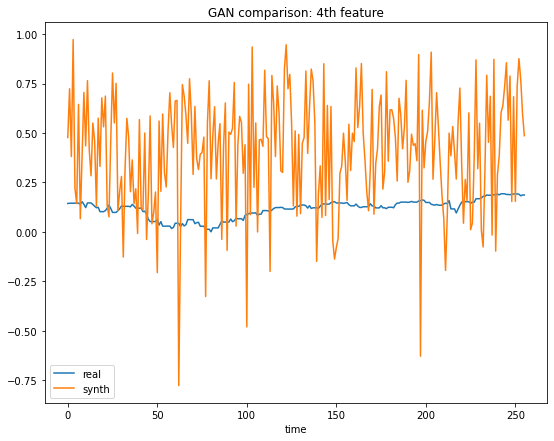

In [53]:
plt.figure(figsize = (9, 7))
plt.plot(x[:, 3], label = 'real')
plt.plot(generator_output[:, 3], label = 'synth')
plt.xlabel("time")
plt.title("GAN comparison: 4th feature")
plt.legend(loc = 'best')
plt.show()

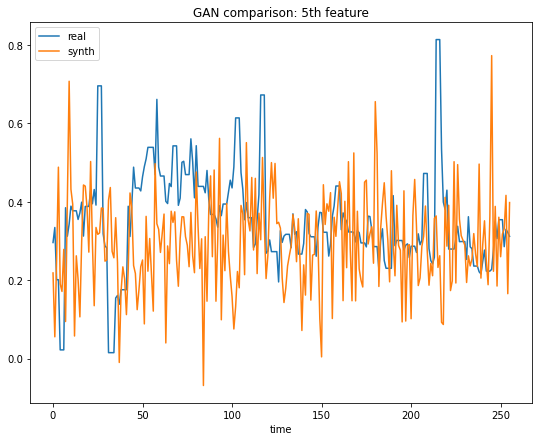

In [54]:
plt.figure(figsize = (9, 7))
plt.plot(x[:, 4], label = 'real')
plt.plot(generator_output[:, 4], label = 'synth')
plt.xlabel("time")
plt.title("GAN comparison: 5th feature")
plt.legend(loc = 'best')
plt.show()

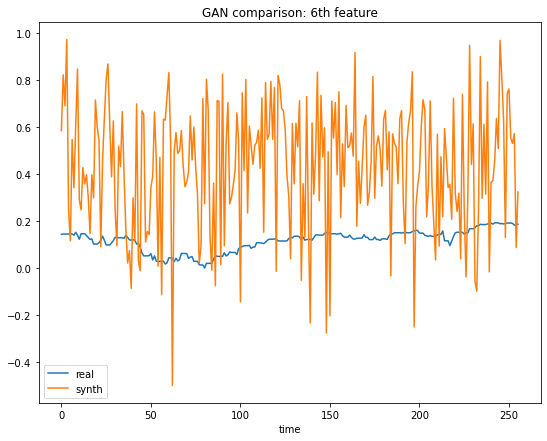

In [55]:
plt.figure(figsize = (9, 7))
plt.plot(x[:, 5], label = 'real')
plt.plot(generator_output[:, 5], label = 'synth')
plt.xlabel("time")
plt.title("GAN comparison: 6th feature")
plt.legend(loc = 'best')
plt.show()

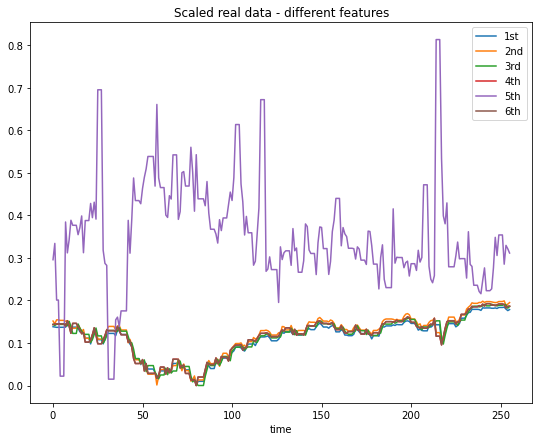

In [56]:
plt.figure(figsize = (9, 7))
plt.plot(x[:, 0], label = '1st')
plt.plot(x[:, 1], label = '2nd')
plt.plot(x[:, 2], label = '3rd')
plt.plot(x[:, 3], label = '4th')
plt.plot(x[:, 4], label = '5th')
plt.plot(x[:, 5], label = '6th')
plt.xlabel("time")
plt.title("Scaled real data - different features")
plt.legend(loc = 'best')
plt.show()

### Observation:

Ofcourse, a vanilla GAN without any Seq2Seq RNN architecture/concept performs horribly ☺